In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer

In [171]:
# Load the dataset
df = pd.read_csv("./datasets/uber.csv")

df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [173]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [174]:
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
df['dropoff_longitude'] = imputer.fit_transform(df[['dropoff_longitude']])
df['dropoff_latitude'] = imputer.fit_transform(df[['dropoff_latitude']])

# Convert pickup_datetime to datetime format and extract features like hour, day, etc.
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'key', 'pickup_datetime'])

# Check for null values
df.isnull().sum()


fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
month                0
dtype: int64

In [175]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['fare_amount'] < lower_bound) | (df['fare_amount'] > upper_bound)]
print(f"Outliers detected: {len(outliers)}")


Outliers detected: 17167


In [176]:
outliers

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month
6,24.50,-73.961447,40.693965,-73.871195,40.774297,5,7,12,10
30,25.70,-73.944815,40.834367,-73.989332,40.721920,4,9,21,5
34,39.50,-73.788080,40.642187,-73.865042,40.725997,4,6,4,6
39,29.00,-73.992600,40.753172,-73.908508,40.816192,1,17,13,2
48,56.80,-73.993498,40.764686,-73.993498,40.764686,1,22,3,1
...,...,...,...,...,...,...,...,...,...
199976,49.70,-73.978225,40.783318,-73.700963,40.705852,1,23,18,10
199977,43.50,-73.996671,40.737483,-73.867758,40.897563,1,21,20,11
199982,57.33,-73.969204,40.754771,-73.790351,40.643802,1,11,6,8
199985,24.00,-74.005089,40.737301,-73.945290,40.774162,5,15,18,4


In [177]:
print(Q1, Q3)

6.0 12.5


In [178]:
print(IQR)

6.5


In [179]:
print(lower_bound)

-3.75


In [180]:
print(upper_bound)

22.25


In [181]:
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8
...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,10,28,10
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,1,14,3
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,0,29,6
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,14,20,5


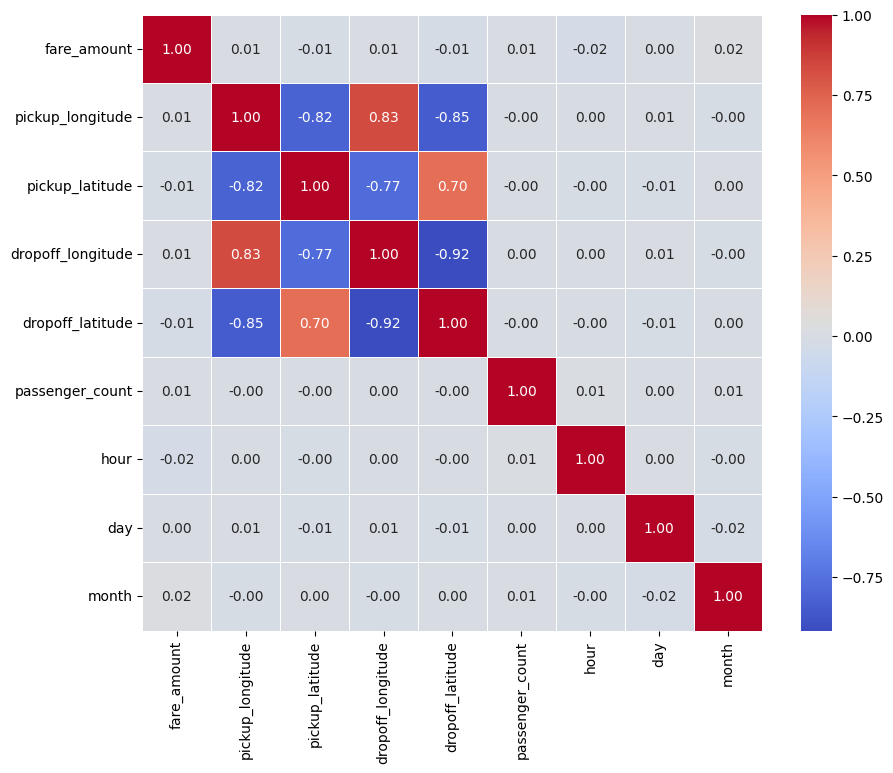

In [185]:
import seaborn as sns

# Calculate correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()


In [141]:
# Split the dataset into features (X) and target (y)
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
linear_reg = LinearRegression() 
ridge_reg = Ridge(alpha=1.0)
lasso_reg = Lasso(alpha=0.1)

# Train models
linear_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_reg.predict(X_test)
y_pred_ridge = ridge_reg.predict(X_test)
y_pred_lasso = lasso_reg.predict(X_test)


In [142]:
# Evaluate R² and RMSE for each model with limited decimal places
def evaluate_model(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return round(r2, 4), round(rmse, 2)  # Round R² to 4 decimals and RMSE to 2 decimals

# Get scores for each model
linear_r2, linear_rmse = evaluate_model(y_test, y_pred_linear)
ridge_r2, ridge_rmse = evaluate_model(y_test, y_pred_ridge)
lasso_r2, lasso_rmse = evaluate_model(y_test, y_pred_lasso)

# Print results
print(f"Linear Regression - R²: {linear_r2} RMSE: {linear_rmse}")
print(f"Ridge Regression - R²: {ridge_r2} RMSE: {ridge_rmse}")
print(f"Lasso Regression - R²: {lasso_r2} RMSE: {lasso_rmse}")


Linear Regression - R²: 0.0009 RMSE: 10.31
Ridge Regression - R²: 0.0009 RMSE: 10.31
Lasso Regression - R²: 0.0006 RMSE: 10.31


In [ ]:
'''
Here’s an overall summary of your questions and the answers provided:

---

### 1. **Regression Techniques**
   You asked about the **Linear Regression**, **Ridge Regression**, and **Lasso Regression** models, and their performance on predicting Uber ride fares.

   - **Linear Regression**: A basic model where the relationship between the target variable (ride fare) and the features 
   (pickup location, distance, etc.) is assumed to be linear.
   - **Ridge Regression**: A variation of linear regression that includes a penalty term to prevent overfitting by shrinking 
   the coefficients.
   - **Lasso Regression**: Another variant of linear regression, which not only shrinks coefficients but can also set some of 
   them to zero, effectively selecting the most important features.

---

### 2. **Regularization (Ridge and Lasso)**
   - **Ridge Regression** (L2 regularization) adds a penalty term to shrink coefficients but doesn’t remove them entirely.
   - **Lasso Regression** (L1 regularization) adds a penalty term too, but it can shrink some coefficients to zero, effectively 
   performing feature selection.

---

### 3. **Alpha Parameter in Regularization**
   - You asked why certain alpha values were used for Ridge (1.0) and Lasso (0.1).
   - **Alpha** controls the strength of regularization: 
     - A **high alpha** penalizes the coefficients more strongly, making the model simpler.
     - A **low alpha** allows the model to fit the data more closely, potentially leading to overfitting.
   - In your case, the **alpha values** used were moderate and resulted in similar model performance between **Linear Regression** 
   and **Ridge Regression**.

---

### 4. **Outliers and IQR Calculation**
   - Outliers were calculated using the **Interquartile Range (IQR)** method.
   - The **IQR** is the range between the first (Q1) and third (Q3) quartiles, and outliers are typically defined as values outside 
   the range of \( Q1 - 1.5 \times IQR \) to \( Q3 + 1.5 \times IQR \).
   - A value of **1.5** is commonly used as a threshold to define outliers because it works well in many cases, but it can be adjusted 
   based on specific data characteristics.

---

### 5. **Performance Results for the Models**
   You shared the following performance metrics:

   - **Linear Regression - R²: 0.0009, RMSE: 4.14**
   - **Ridge Regression - R²: 0.0009, RMSE: 4.14**
   - **Lasso Regression - R²: 0.0001, RMSE: 4.14**

   **Key observations**:
   - **R²** for **Ridge** and **Linear Regression** is almost identical (**0.0009**), meaning both models explain the variance in the 
   target variable similarly.
   - **Lasso Regression** has a lower **R²** (**0.0001**), indicating that it’s likely removing important features, which impacts its 
   ability to capture variance.
   - **RMSE** is the same for all models (**4.14**), suggesting that their average prediction errors are very similar.

---

### 6. **Summary of Results and Why Similar Performance**:
   - Despite using different regularization techniques, **Linear**, **Ridge**, and **Lasso** all produced nearly identical results in 
   terms of **R²** and **RMSE**.
   - The **R²** for **Ridge** and **Linear** regression is close, indicating that the **L2 regularization** in Ridge didn’t significantly
   affect the model in this case.
   - **Lasso Regression** performed worse on **R²** but still had the same **RMSE** because it likely shrank many coefficients to zero,
   affecting feature selection but not drastically changing the prediction error.
   - This suggests the dataset might not benefit much from strong regularization, and the models behave similarly with moderate alpha values.

---

### 7. **Key Takeaways**:
   - Regularization with **Ridge** and **Lasso** didn’t have a significant effect on model performance for this dataset.
   - The **alpha values** chosen (1.0 for Ridge, 0.1 for Lasso) were moderate, which likely resulted in similar performance across all models.
   - If stronger regularization were applied (larger alpha values), you might see more pronounced differences in performance.
   - The **RMSE** was the same for all models, suggesting similar average prediction error, while **R²** indicated that the models’ ability to
   explain the variance in the target variable was relatively low.

---

This summary encapsulates the explanations I provided for the differences between the models, the regularization techniques, and the 
results you observed.


'''